# STEP 1 - Basic OFDM chain

We will simulate a basic ofdm chain on a AWGN channel
https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html

In [140]:
import numpy as np
import matplotlib.pyplot as plt

allCarriers:   [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
dataCarriers:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 11

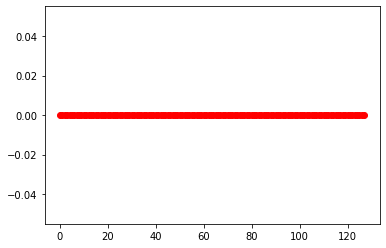

In [141]:

#######################TRANSMISSION CARACTERISTICS##########################

K = 128 # number of OFDM subcarriers
CP = 16  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
#pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])


# data carriers are all remaining carriers
dataCarriers = allCarriers

print ("allCarriers:   %s" % allCarriers)

print ("dataCarriers:  %s" % dataCarriers)
# plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')


mu = 2 # bits per symbol (i.e. 4QAM)
payloadBits_per_OFDM = K*mu  # number of payload bits per OFDM symbol

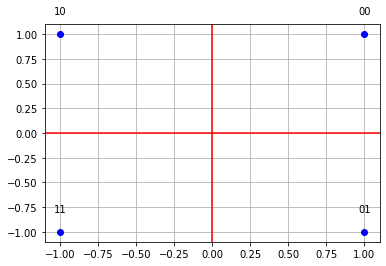

In [142]:

#######################CONSTELLATION##########################
mapping_table = {
    (1,1) : -1-1j,
    (1,0) : -1+1j,
    (0,1) :  1-1j,
    (0,0) :  1+1j
}
for b1 in [0, 1]:
    for b0 in [0, 1]:
        B = ( b1, b0)
        Q = mapping_table[B]
        plt.plot(Q.real, Q.imag, 'bo')
        plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
                
plt.axhline(0,color='red') # x = 0
plt.axvline(0,color='red') # y = 0
plt.grid()
plt.show()                   

Ici la variance vaut $$(\sqrt(1²+1j²))²$$ = 2

In [143]:
demapping_table = {v : k for k, v in mapping_table.items()}

In [144]:

#######################RANDOM SYMBOLS##########################

bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))
    


Bits count:  256
First 20 bits:  [1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0]
Mean of bits (should be around 0.5):  0.51171875


In [145]:

#######################SERIAL->PARALLEL##########################
"""
On met par paquet la séquence précédemment créée (paquet de 4 car 1symb = 4 bits
"""
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])


First 5 bit groups
[[1 0]
 [1 1]
 [0 0]
 [1 0]
 [1 1]]


In [146]:

#######################MAPPING##########################

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[1 0]
 [1 1]
 [0 0]
 [1 0]
 [1 1]]
[-1.+1.j -1.-1.j  1.+1.j -1.+1.j -1.-1.j]


In [147]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    #symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))

Number of OFDM carriers in frequency domain:  128


In [148]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  128


In [149]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))
OFDM_TX = OFDM_withCP

Number of OFDM samples in time domain with CP:  144


In [150]:
print(OFDM_TX[:5])

[ 0.125     -0.08570752j  0.03781197-0.01780679j -0.19480002-0.10357099j
  0.21544382+0.1012786j  -0.05698184+0.01878914j]


In [151]:
def awgn(TX, var):
    num=len(TX)
    print(num)
    noisei = np.random.normal(0,var,num)
    noisej = 1j*np.random.normal(0,var,num)
    RX = TX[:]+noisei[:]+noisej[:]
    print(RX[:5])
    return RX

OFDM_RX = awgn(OFDM_TX,0.01)

144
[ 0.12100044-0.07230556j  0.04833947-0.00398534j -0.19091784-0.1054422j
  0.2329518 +0.10510782j -0.04996928+0.02979594j]


In [152]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX) #ICI j'ai pris TX

In [153]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

# CHANNEL esitimate not done

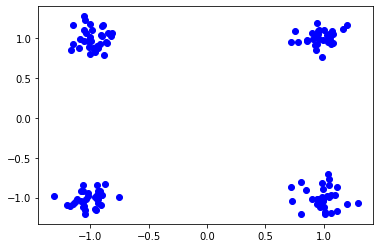

In [154]:
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(OFDM_demod)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');

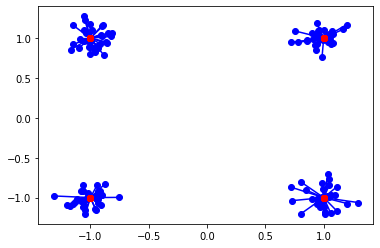

In [155]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

In [156]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)


In [157]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.0
